In [36]:
import os
from os.path import join as oj
import sys
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
from data_load_process import data


import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from copy import deepcopy
import pickle as pkl
import pandas as pd

## parameters

In [31]:
# saving
out_dir = '/scratch/users/vision/chandan/dl_theory' # differs for chandan/raaz

class p:
    # data parameters
    N = 2000 # N is batch size
    layer_sizes = [1, 10, 2] # input, hidden1, hidden..., output
    means = [[0], [20], [40]] # means of gaussian data
    sds = [[1], [1], [1]] # sds of data
#     means = [[0], [20]]
#     sds = [[1], [1]]
    labs = [0, 1, 0] # labels of these gaussians
#     labs = [0, 1]
    batch_size = 200
    
    # model parameters
    num_layers = len(layer_sizes) - 1
    
    # fitting paramters
    lr = 1e-6
    num_iters = 200
    step_size_optimizer = 1000
    gamma_optimizer = 0.9
    
    # random seed
    seed = 2
    
    
    def _str(self):
        s = '___'.join("%s=%s" % (attr, val) for (attr, val) in vars(p).items()
                       if not attr.startswith('_'))
        return s.replace('/', '')[:251] # filenames must fit in byte 
    
    def _dict(self):
        return {attr: val for (attr, val) in vars(p).items()
                 if not attr.startswith('_')}
    
# set params
use_cuda = torch.cuda.is_available()
if not use_cuda: # running on cluster
    for i in range(1, len(sys.argv), 2):
        t = type(getattr(p, sys.argv[i]))
        setattr(p, sys.argv[i], t(sys.argv[i+1]))

## run + fit

In [52]:
# set random seed        
np.random.seed(p.seed) 
torch.manual_seed(p.seed)

# generate data
X, y, y_plot = data.generate_gaussian_data(p.N, means=p.means, sds=p.sds, labs=p.labs)
dset = data.dset(X, y)
'''
plt.scatter(X, y_plot)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
'''

# make model
model = torch.nn.Sequential(
    torch.nn.Linear(p.layer_sizes[0], p.layer_sizes[1]),
    torch.nn.ReLU(),
#     torch.nn.Linear(p.layer_sizes[1], p.layer_sizes[2]),
#     torch.nn.ReLU(),
    torch.nn.Linear(p.layer_sizes[-2], p.layer_sizes[-1]),
    torch.nn.Softmax()
)


# freeze
# model.2.weight = 2
# instead of model.parameters(), only pass what you wanna optimize

# set up optimization
optimizer = torch.optim.SGD(model.parameters(), lr=p.lr) # only optimize ridge (otherwise use model.parameters())
scheduler = StepLR(optimizer, step_size=p.step_size_optimizer, gamma=p.gamma_optimizer)
loss_fn = torch.nn.MSELoss(size_average=False)
dataloader = DataLoader(dset, batch_size=p.batch_size, shuffle=True)


# to record
weights = {}
losses = np.zeros(p.num_iters)
norms = np.zeros((p.num_iters, p.num_layers))
accs = np.zeros(p.num_iters)


# fit
for it in tqdm(range(p.num_iters)):
    for batch in dataloader:
        y_pred = model(Variable(batch['x'], requires_grad=True)) # predict
        loss = loss_fn(y_pred, Variable(batch['y'])) # calculate loss
        optimizer.zero_grad() # zero the gradients
        loss.backward() # backward pass
        optimizer.step() # update weights
        scheduler.step() # step for incrementing optimizer

        # output
        weight_dict = deepcopy({x[0]:x[1].data.numpy() for x in model.named_parameters()})
        if it % 100 == 0:
            weights[it] = weight_dict
        losses[it] = loss.data[0] 
        accs[it] = np.mean(np.argmax(y_pred.data.numpy(), axis=1) == y_plot) * 100
        norms[it, 0] = np.linalg.norm(weight_dict['0.weight'])**2 + np.sum(weight_dict['0.bias']**2)
        norms[it, 1] = np.linalg.norm(weight_dict['2.weight'])**2 + np.sum(weight_dict['2.bias']**2)
    
# save
if not os.path.exists(out_dir):  # delete the features if they already exist
    os.makedirs(out_dir)
params = p._dict(p)
results = {'weights': weights, 'losses': losses, 'norms': norms, 'accs': accs}
pkl.dump({**params, **results}, open(oj(out_dir, p._str(p) + '.pkl'), 'wb'))

  0%|          | 0/200 [00:00<?, ?it/s]/accounts/projects/vision/.local/lib/python3.5/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 200/200 [00:05<00:00, 33.79it/s]


# analyze results

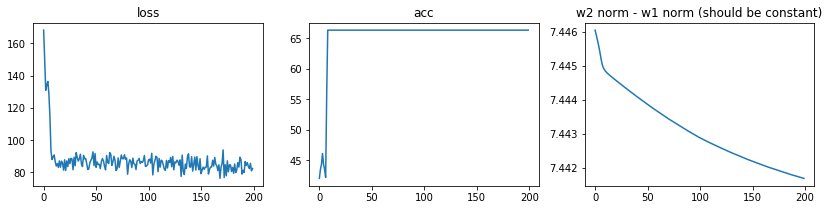

82.36299133300781


In [18]:
# plot loss and norms
plt.figure(figsize=(14, 3))
plt.subplot(131)
plt.plot(losses)
plt.title('loss')

plt.subplot(132)
plt.plot(accs)
plt.title('acc')

plt.subplot(133)
plt.plot(norms[:, 0] - norms[:, 1])
plt.title('w2 norm - w1 norm (should be constant)')
plt.show()

print(losses[-1])

# plotting preds

/accounts/projects/vision/.local/lib/python3.5/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


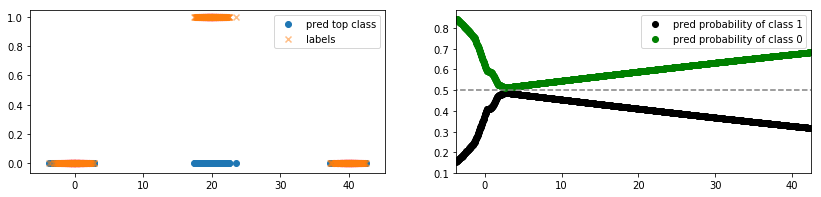

In [509]:
# plot predictions
plt.figure(figsize=(14, 3))
plt.subplot(121)
preds = model(Variable(torch.from_numpy(X), requires_grad=True)).data.numpy() # predict
plt.scatter(X, np.argmax(preds, axis=1), label='pred top class')
plt.scatter(X, np.argmax(y, axis=-1), label='labels', alpha=0.5, marker='x')
plt.legend()

plt.subplot(122)
X_grid = np.linspace(np.min(X), np.max(X), 1000, dtype=np.float32).reshape(X_grid.shape[0], 1)
preds_grid = model(Variable(torch.from_numpy(X_grid), requires_grad=True)).data.numpy() # predict
plt.scatter(X_grid, preds_grid[:, 1], label='pred probability of class 1', color='black') # note other class is 1 - this
plt.scatter(X_grid, preds_grid[:, 0], label='pred probability of class 0', color='green') # note other class is 1 - this
plt.plot([-1000, 1000], [.5, .5], '--', color='gray')
plt.xlim([np.min(X), np.max(X)])
plt.legend()
plt.show()